In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr
from tools import savefig, fix_figure, coef_var, corrcoef
import copy
from IPython.display import display

rc = {
    'figure.figsize' : (9, 9),
    'axes.labelsize' : 25,
    'lines.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.titlesize' : 20,
    'font.size'      : 20,
    'legend.frameon' : False,
    'legend.fontsize': 20,
    'font.family'    : 'serif',
#     'font.serif'     : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#     'font.sans-serif': Helvetica, Avant Garde, Computer Modern Sans serif
#     'font.cursive'   : Zapf Chancery
#     'font.monospace' : Courier, Computer Modern Typewriter
    'text.usetex'    : True}
sns.set(rc=rc)
sns.set_color_codes()
sns.set_style('white')
plt.rcParams.update(rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,rate_in,rate_ex
0,3.733333,4.194858


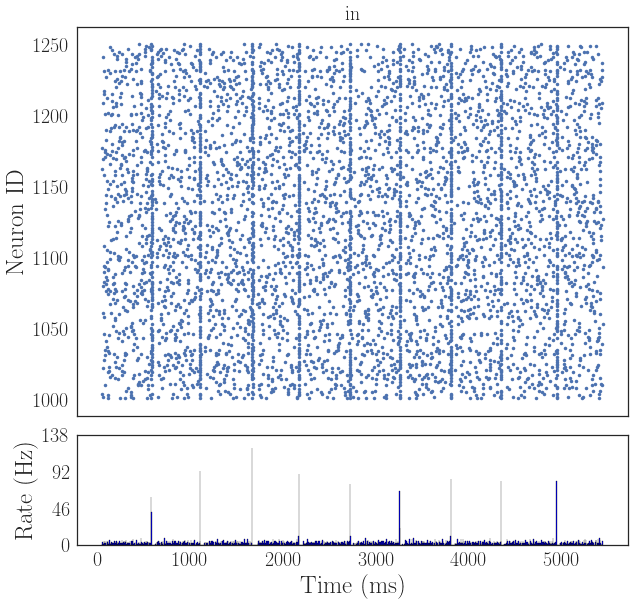

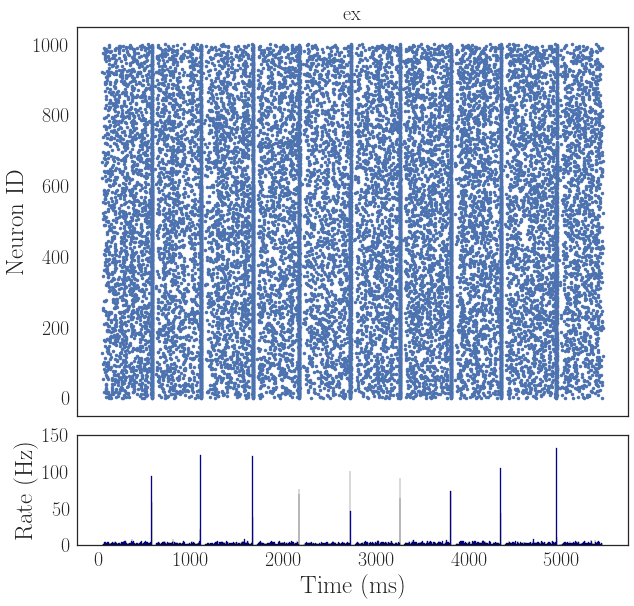

In [3]:
from params_AI import parameters
sim = Simulator(parameters, fname='voltage_dist_AI', data_path='results', 
                stim_N=9, stim_period=500, stim_max_period=600, stim_dist='poisson', stim_amp_ex=10.0,
                N_rec_state_ex=100, N_rec_state_in=1)
#                 pulse_dist=pulses, pulse_activity=1, pulse_std=4., pulse_J=1.)
sim.simulate(state=True, save=True, raster=True)

# from params_SI import parameters
# sim = Simulator(parameters, fname='voltage_dist_SI', data_path='results', 
#                 stim_N=9, stim_period=500, stim_dist=None, stim_amp_ex=10.0,
#                 N_rec_state_ex=100, N_rec_state_in=1)
# sim.simulate(state=True, save=True, raster=True)

pd.DataFrame([sim.data['params']]).loc[:,['rate_in', 'rate_ex']]

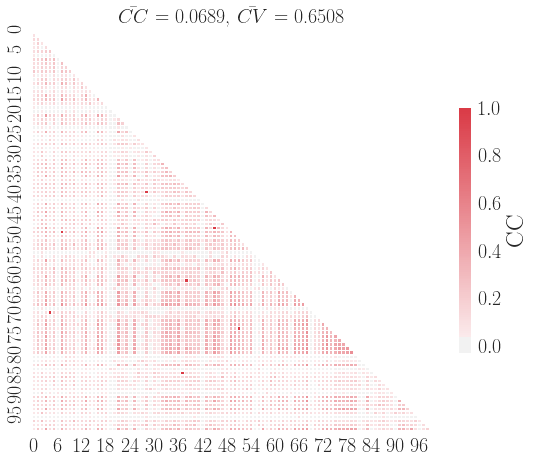

In [21]:
N = 100
binsize = 5

idx = np.random.randint(1,1000, N)
t_stop = sim.data['params']['status']['time']
spiketrains = [sim.data['spiketrains']['ex'][i]['times'] for i in idx
              if i < len(sim.data['spiketrains']['ex'])]

cv = np.array([np.diff(t).std()/np.diff(t).mean()
               for t in [s['times'] for s in sim.data['spiketrains']['ex']] 
               if len(t) > 1])

ccg = corrcoef(spiketrains, t_stop, binsize)
m = np.triu(ccg, k=1)
mask = np.zeros_like(ccg, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ccg, mask=mask, cmap=cmap, vmax=m.max(), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, 'label': 'CC'})
plt.title('$\\bar{{CC}}$ = {:.4f}, $\\bar{{CV}}$ = {:.4f}'.format(m.mean(), cv.mean()));

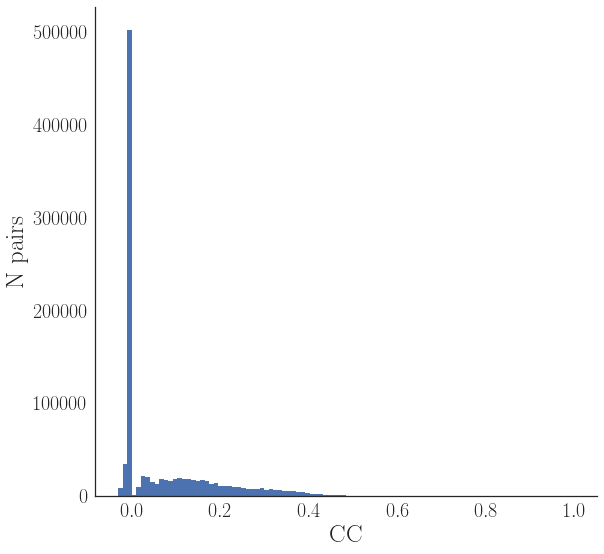

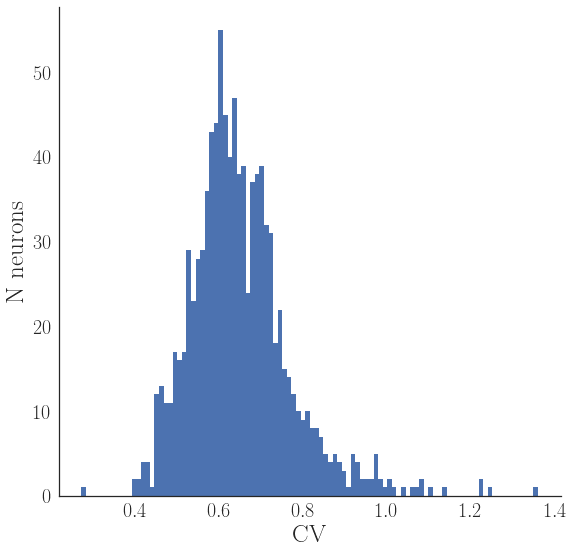

In [5]:
figsize = (9,9)
plt.figure(figsize=figsize)
plt.hist(m.flatten(), bins=100);
plt.xlabel('CC')
plt.ylabel('N pairs')
sns.despine()

plt.figure(figsize=figsize)
plt.hist(cv, bins=100);
plt.xlabel('CV')
plt.ylabel('N neurons')
sns.despine()

In [6]:
data = sim.data
# data = np.load('results/voltage_dist_AI.npz')['data'][()]
# data = np.load('results/voltage_dist_SI.npz')['data'][()]

In [7]:
pop = 'ex'
senders = data['state'][pop]['senders']
V = data['state'][pop]['V_m']
senders_unique = list(set(senders))
nsamples = sum(senders==senders_unique[0])
nsenders = len(senders_unique)
state = np.zeros((nsenders, nsamples))
for i, sender in enumerate(senders_unique):
    state[i,:] = V[senders==sender]
times = data['state'][pop]['times'][senders==sender]

In [8]:
df = pd.DataFrame(state, index=senders_unique, columns=times.round())

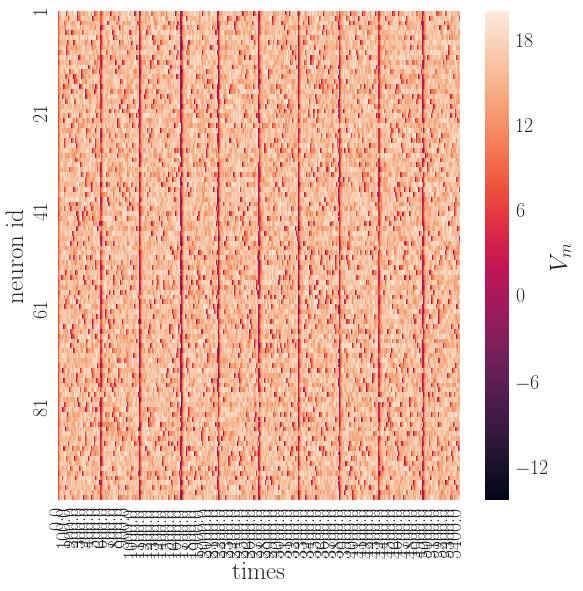

In [9]:
df.index.name = 'neuron id'
df.columns.name = 'times'
sns.heatmap(df, cbar_kws={'label': '$V_m$'},
           xticklabels=1000, yticklabels=20)

In [14]:
bins = np.arange(-20, 20, .5)
t = times[::10]
hist = np.zeros((len(bins)-1, len(t)))
for ii, pot in enumerate(state[:,::10].T):
    h, b = np.histogram(pot, bins=bins, density=True)
    hist[:,ii] = h[::-1]

In [15]:
df_hist = pd.DataFrame(hist, index=bins[::-1][:-1].round(), columns=t.round())

In [16]:
df_hist[df_hist==0] = 1e-6

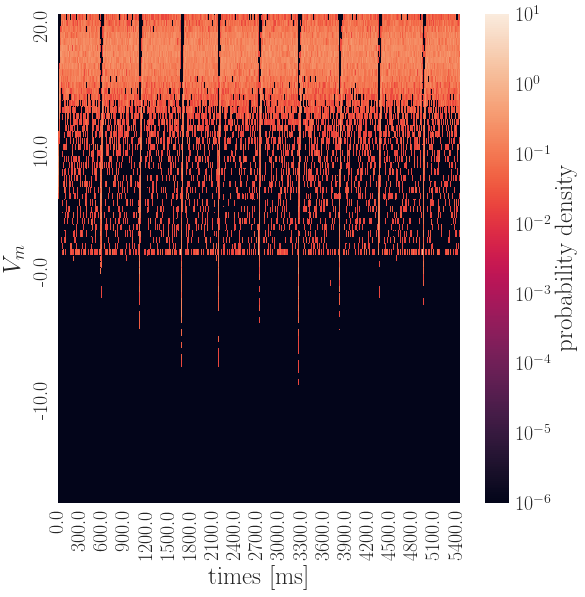

In [17]:
from matplotlib.colors import LogNorm
df_hist.index.name = '$V_m$'
df_hist.columns.name = 'times [ms]'
cbar_kws = {'label': 'probability density', 
            'ticks': [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]}
axs = sns.heatmap(df_hist, cbar_kws=cbar_kws,
                  norm=LogNorm(vmin=df_hist.min(), vmax=df_hist.max()),
                  vmin=min(cbar_kws['ticks']), vmax=max(cbar_kws['ticks']),
                 xticklabels=300, yticklabels=20)